In [1]:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [2]:
import sys, torch, os
import importlib, utils
import pickle
import networkx as nx
import pickle
from random import shuffle
import random
import matplotlib.pyplot as plt
from torchviz import make_dot
print("[DEBUG] torchviz imported:", make_dot)


import numpy as np

# Patch for deprecated np.float_ in NumPy 2.x
if not hasattr(np, 'float_'):
    np.float_ = np.float64
    
import pyemd
print(pyemd.__file__)




# importlib.reload(utils)
from utils import mean_graph_discrepancy, load_graph_list
# from evaluate import *

os.environ["PATH"] = os.path.dirname(sys.executable) + ":" + os.environ["PATH"]

import os
os.environ["LD_LIBRARY_PATH"] = "/gpfs/fs1/home/sjaferia/conda-envs/torch-env/lib:" + os.environ.get("LD_LIBRARY_PATH", "")


[DEBUG] torchviz imported: <function make_dot at 0x14bb49d42550>


/gpfs/fs1/home/sjaferia/conda-envs/torch-env/lib/python3.9/site-packages/pyemd/__init__.py:74: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from .emd import emd, emd_with_flow, emd_samples


/gpfs/fs1/home/sjaferia/conda-envs/torch-env/lib/python3.9/site-packages/pyemd/__init__.py


In [3]:
print("Python:", sys.executable)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH", ""))

Python: /gpfs/fs1/home/sjaferia/conda-envs/torch-env/bin/python
Torch version: 2.5.1+cu121
CUDA available: True
LD_LIBRARY_PATH: /gpfs/fs1/home/sjaferia/conda-envs/torch-env/lib:/software/slurm/24.05.0.b1/lib64:/software/slurm/24.05.0.b1/lib


## Generating Graphs

In [6]:
# def make_correlated_graph(n_nodes=100):
#     G = nx.gn_graph(n_nodes, seed=random.randint(0, 10**6))
#     for node in G.nodes:
#         if G.in_degree(node) == 2:
#             G.nodes[node]["rule"] = "A and B" if node % 2 == 0 else "A or B"
#     return G

# # os.makedirs("train_data", exist_ok=True)

# # Generate graphs
# graphs = [make_correlated_graph() for _ in range(100)]

# # save inside train_data folder
# output_path = "real_data/train_data.dat"
# with open(output_path, "wb") as f:
#     pickle.dump(graphs, f)

# print(f"Saved {len(graphs)} Boolean graphs to {output_path}")

Saved 100 Boolean graphs to real_data/train_data.dat


In [3]:
data = pickle.load(open('./real_data/train_data.dat', 'rb'))
# data = pickle.load(open('./synthetic_data/GraphRNN_RNN_nobfs_KEGG_4_128_pred_600_1.dat', 'rb'))

print(f"Total entries: {len(data)}")
for i, item in enumerate(data):
    print(f"\nEntry {i}:")
    print("Type:", type(item))
    print("Content preview:", str(item)[:200])  # Print first 200 characters


Total entries: 87

Entry 0:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 39 nodes and 84 edges

Entry 1:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 37 nodes and 94 edges

Entry 2:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 34 nodes and 92 edges

Entry 3:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 21 nodes and 30 edges

Entry 4:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 26 nodes and 50 edges

Entry 5:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 26 nodes and 62 edges

Entry 6:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 12 nodes and 17 edges

Entry 7:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 28 nodes and 54 edges

Entry 8:
Type: <class 'networkx.classes.digraph.DiGraph'>
Content preview: DiGraph with 39 no

In [ ]:
import importlib, utils
from model import *

# Don't forget to reload this
importlib.reload(utils)
from utils import load_graph_list


!python main.py

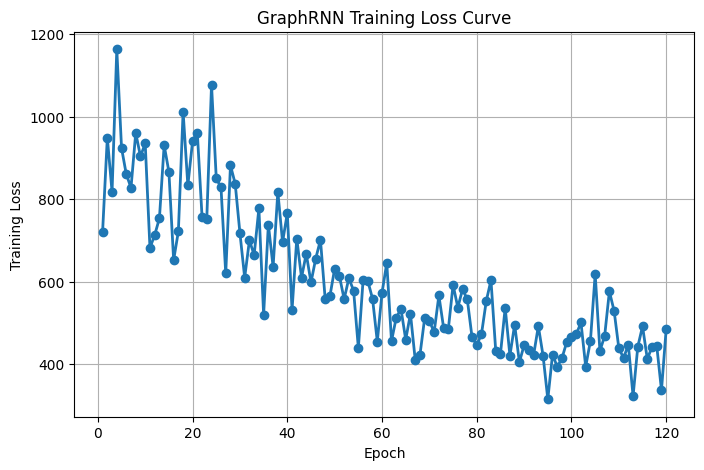

In [7]:
losses = np.load("timing/GraphRNN_RNN_KEGG_4_128__loss.npy")
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses)+1), losses, marker='o', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("GraphRNN Training Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
losses = np.load("timing/GraphRNN_RNN_KEGG_4_128__loss.npy")
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses)+1), losses, marker='o', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("GraphRNN Training Loss Curve")
plt.grid(True)
plt.show()

In [5]:
# data = pickle.load(open('./synthetic_data/test_data0.dat', 'rb'))
# G = data[16]

# print(len(data))
# print("Type:", type(G))
# print("Number of nodes:", G.number_of_nodes())
# print("Node labels:", list(G.nodes())[:10])
# print("Number of edges:", G.number_of_edges())
# print("First 10 edges:", list(G.edges())[:10])

# for n in G.nodes():
#     if n not in G.adj:
#         print("Missing adjacency entry for node:", n)

## Some Evaluations

In [6]:
from eval.stats import degree_stats, clustering_stats, orbit_stats_all
import networkx as nx
import utils

# Load real and synthetic graphs
real_graphs = utils.load_graph_list('./real_data/train_data.dat', is_real=True)
synthetic_graphs = utils.load_graph_list('./synthetic_data/GraphRNN_RNN_KEGG_4_128_pred_100_1.dat', is_real=False)

# Trim to same length
synthetic_graphs = synthetic_graphs[:len(real_graphs)]

# Clean duplicate edges and self-loops
def clean_graphs(graphs):
    cleaned = []
    for G in graphs:
        G = nx.Graph(G)  # make simple undirected (deduplicates edges)
        G.remove_edges_from(nx.selfloop_edges(G))
        cleaned.append(G)
    return cleaned

real_graphs = clean_graphs(real_graphs)
synthetic_graphs = clean_graphs(synthetic_graphs)

# Eval
mmd_degree = degree_stats(real_graphs, synthetic_graphs)
mmd_clustering = clustering_stats(real_graphs, synthetic_graphs)
try:
    mmd_orbits = orbit_stats_all(real_graphs, synthetic_graphs)
except Exception as e:
    print("ORCA failed:", e)
    mmd_orbits = -1

print("-------------------------")
print("MMD Degree:", mmd_degree)
print("MMD Clustering:", mmd_clustering)
print("MMD 4-Orbits:", mmd_orbits)

87 87
-------------------------
[ 4.0973837   9.89835618  4.94917809  7.06296502 14.22121053 14.22121053
 10.65381784  3.55127261  5.45467643 10.19917607 20.39835215 10.19917607
  6.46348712  6.46348712 13.37100338]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------
-------------------------
MMD Degree: 1.1379478634867308
MMD Clustering: 0.7719279782982551
MMD 4-Orbits: 0.22408945032836947


In [7]:
import random
random.seed(0)

real = load_graph_list('./real_data/train_data.dat', is_real=True)
gen  = load_graph_list('./synthetic_data/GraphRNN_RNN_KEGG_4_128_pred_100_1.dat', is_real=False)

# uniform subsample synthetic -> same count as real
gen = random.sample(gen, k=len(real))

m = mean_graph_discrepancy(real, gen)
for k, v in m.items():
    print(f"{k}: {v:.4f}")

num_nodes: 22.7701
num_edges: 62.1379
degree_mean: 4.1128
clustering_mean: 0.1827
overall_mean_discrepancy: 22.3009
